In [107]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.utils import shuffle
import xgboost as xgb
import matplotlib.pyplot as plt

# Import and Concatenate Data

In [108]:
# We assume there i*s an equal amount of the labels
data_length = 740 # TODO I don't want to set this in advance

In [111]:
subject_feature_dfs = {}

labels = []

for subject_idx, subject in enumerate(["m292", "m294"]): #,  "m298", "m298", "m299", "m300"]):
    
    subject_feature_dfs[subject] = pd.DataFrame(index=range(data_length), columns=['Subject'])
    data_length = 0

    for data_type in ["EEG", "EMG"]: 
        
        train_feature_df = pd.read_csv("Features/"+str(subject)+"/Train/"+str(data_type)+"/Topological_Summary_Statistics.csv")
        train_advanced_feature_df = pd.read_csv("Features/"+str(subject)+"/Train/"+str(data_type)+"/Advanced_Features.csv")
        train_statistical_features = pd.read_csv("Features/"+str(subject)+"/Train/"+str(data_type)+"/Statistical_Features.csv")
        #train_wasserstein_features = pd.read_csv("Features/"+str(subject)+"/Train/"+str(data_type)+"/Wasserstein_Features.csv")
        #train_landscape_features = pd.read_csv("Features/Train_"+str(data_type)+"_Landscape_Features.csv")
        #train_bottleneck_features = pd.read_csv("Features/Train_"+str(data_type)+"_bottleneck_Features.csv")
        #train_signature_features = pd.read_csv("Features/Train_"+str(data_type)+"_Signature_Statistics.csv")
        #train_vectorization_features = pd.read_csv("Features/Train_"+str(data_type)+"_Vectorization_Features.csv")


        test_feature_df = pd.read_csv("Features/"+str(subject)+"/Test/"+str(data_type)+"/Topological_Summary_Statistics.csv")
        test_advanced_feature_df = pd.read_csv("Features/"+str(subject)+"/Test/"+str(data_type)+"/Advanced_Features.csv")
        test_statistical_features = pd.read_csv("Features/"+str(subject)+"/TEST/"+str(data_type)+"/Statistical_Features.csv")
        
        #test_wasserstein_features = pd.read_csv("Features/"+str(subject)+"/Test/"+str(data_type)+"/Wasserstein_Features.csv")
        #test_landscape_features = pd.read_csv("Features/Test_"+str(data_type)+"_Landscape_Features.csv")
        #test_bottleneck_features = pd.read_csv("Features/Test_"+str(data_type)+"_bottleneck_Features.csv")
        #test_signature_features = pd.read_csv("Features/Test_"+str(data_type)+"_Signature_Statistics.csv")
        #test_vectorization_features = pd.read_csv("Features/Test_"+str(data_type)+"_Vectorization_Features.csv")

        data_length += len(train_feature_df.index) +  len(train_statistical_features.index)
        data_length += len(test_feature_df.index) +  len(test_statistical_features.index)
        
        # Concatenate train and test sets (and split again later) to not get a problem with indices
        summary_statistics = pd.concat([train_feature_df, test_feature_df], ignore_index=True)
        advanced_features = pd.concat([train_advanced_feature_df, test_advanced_feature_df], ignore_index=True)
        statistical_features = pd.concat([train_statistical_features, test_statistical_features], ignore_index=True)
        #wasserstein_features =  pd.concat([train_wasserstein_features, test_wasserstein_features], ignore_index=True)
        #landscape_features =  pd.concat([train_landscape_features, test_landscape_features], ignore_index=True)
        #bottleneck_features =  pd.concat([train_bottleneck_features, test_bottleneck_features], ignore_index=True)
        #signature_features =  pd.concat([train_signature_features, test_signature_features], ignore_index=True)
        #vectorization_features =  pd.concat([train_vectorization_features, test_vectorization_features], ignore_index=True)

        # TODO put this into loop below
        summary_statistics["Subject"] = subject_idx
        statistical_features["Subject"] = subject_idx
        #wasserstein_features["Subject"] = subject_idx
        advanced_features["Subject"] = subject_idx



        labels.extend(summary_statistics["Label"])

        list_of_dataframes =  [summary_statistics, statistical_features, advanced_features]#, wasserstein_features]#, , , , \
                               #vectorization_features, signature_features, bottleneck_features]

        for df in list_of_dataframes:
            # We do not want the labels in the training data
            df.drop(columns = ["Label"], inplace = True)
            # All dataframes come with unnamed columns TODO
            df.drop(df.columns[df.columns.str.contains('unnamed',case = False)], axis = 1, inplace = True)

        # Choose one, several or all of the following dataframes
        subject_feature_dfs[subject] = subject_feature_dfs[subject].join(summary_statistics, lsuffix='_left', rsuffix='') # mostly improves result, depending on the other features
        subject_feature_dfs[subject].drop(subject_feature_dfs[subject].columns[subject_feature_dfs[subject].columns.str.contains('_left',case = False)], axis = 1, inplace = True)
        
        subject_feature_dfs[subject] = subject_feature_dfs[subject].join(statistical_features, lsuffix='_left', rsuffix='') # mostly improves result, depending on the other features
        subject_feature_dfs[subject].drop(subject_feature_dfs[subject].columns[subject_feature_dfs[subject].columns.str.contains('_left',case = False)], axis = 1, inplace = True)


        subject_feature_dfs[subject] = subject_feature_dfs[subject].join(advanced_features, lsuffix='_left', rsuffix='') # mostly improves result, depending on the other features
        subject_feature_dfs[subject].drop(subject_feature_dfs[subject].columns[subject_feature_dfs[subject].columns.str.contains('_left',case = False)], axis = 1, inplace = True)

        #subject_feature_dfs[subject] = subject_feature_dfs[subject].join(wasserstein_features, lsuffix='_left', rsuffix='') # mostly improves result, depending on the other features
        #subject_feature_dfs[subject].drop(subject_feature_dfs[subject].columns[subject_feature_dfs[subject].columns.str.contains('_left',case = False)], axis = 1, inplace = True)

    
        #feature_df = feature_df.join(wasserstein_features) # only improves result if advanced_features is not used
        #feature_df = feature_df.join(advanced_features) # improves result by a lot, also works well alone
        #feature_df = feature_df.join(bottleneck_features) # good standalone accuracy, but worsens result
        #feature_df = feature_df.join(signature_features) # currently does not change the result?
        #feature_df = feature_df.join(vectorization_features) 

        
    

#feature_df = pd.concat([subject_feature_dfs["m292"], subject_feature_dfs["m294"], subject_feature_dfs["m298"], subject_feature_dfs["m299"], subject_feature_dfs["m300"]], ignore_index=True)

#feature_df = subject_feature_dfs["m292"]

feature_df = pd.concat([subject_feature_dfs["m292"], subject_feature_dfs["m294"]], ignore_index=True)


In [113]:
data_length//2

740

In [114]:
# Save dataframe for data exploration
feature_df.to_csv("Features/All_Features.csv")

# Preprocess Data

In [115]:
feature_df = feature_df.dropna()

In [116]:
# Use boolean indexing to find indices where Column2 has the target value
train_indices = feature_df.index[feature_df['Train'] == True]
test_indices = feature_df.index[feature_df['Train'] == False]

X_train = feature_df.loc[train_indices]
y_train = [labels[idx] for idx in train_indices]

X_test = feature_df.loc[test_indices]
y_test = [labels[idx] for idx in test_indices]

In [117]:
# Random Forest

In [118]:
rf = RandomForestClassifier(random_state=5, n_estimators = 900)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
print("Accuracy:", accuracy)

/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Accuracy: 0.7217391304347827


/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


/var/folders/f_/tyg450s17m53dh3ylrjcmpqc0000gn/T/ipykernel_59818/2717088851.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forest_importances[feature_indices].plot.bar(yerr=std[feature_indices], ax=ax)


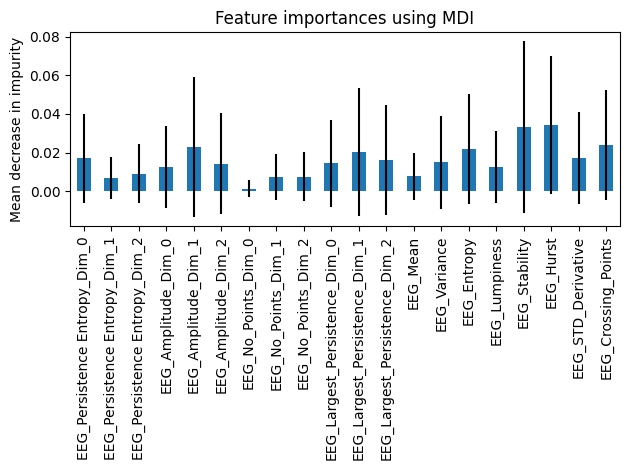

In [119]:
feature_indices = np.arange(0,20)
#feature_indices = np.arange(20,40)
#feature_indices = np.arange(40,60) 
#feature_indices = np.arange(60,80)
#feature_indices = np.arange(80,100)


importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_df.columns)


fig, ax = plt.subplots()
forest_importances[feature_indices].plot.bar(yerr=std[feature_indices], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [120]:
# Recursive Feature Elimination for Random Forest
from sklearn.feature_selection import RFE

rfe = RFE(rf, n_features_to_select=196)
rfe.fit(X_train, y_train)

y_pred = rfe.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
print("Accuracy:", accuracy)

# Has a negative effect if not all features are selected (with current parameters)

/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Accuracy: 0.7217391304347827


/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [25]:
# Pruning features with low feature importance manually
# ...

In [26]:
# XGBoost

In [27]:
""" Does not have an effect
# Scaling for XGBoost

from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame with features
# You might want to exclude the target variable if it's included in the DataFrame

# Extract the feature columns
feature_columns = feature_df.columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the features using the scaler
df_scaled = pd.DataFrame(scaler.fit_transform(feature_df), columns=feature_columns)


# Split data frame again (for each label)
train_label_length = int(0.7*(data_length/5))
train_data_length = train_label_length*5

test_label_length = int(0.7*(data_length/5))+1
test_data_length = test_label_length*5

X_train = pd.DataFrame()
y_train = []

X_test = pd.DataFrame()
y_test = []

for label_idx in range(5):
    X_train = pd.concat([X_train, df_scaled[train_label_length*label_idx:train_label_length*(label_idx+1)]], ignore_index=True)
    y_train.extend(labels[train_label_length*label_idx:train_label_length*(label_idx+1)])

    X_test = pd.concat([X_test, df_scaled[train_label_length+test_label_length*label_idx:train_label_length+test_label_length*(label_idx+1)]])
    y_test.extend(labels[train_label_length+test_label_length*label_idx:train_label_length+test_label_length*(label_idx+1)])

""" 

" Does not have an effect\n# Scaling for XGBoost\n\nfrom sklearn.preprocessing import StandardScaler\n\n# Assuming df is your DataFrame with features\n# You might want to exclude the target variable if it's included in the DataFrame\n\n# Extract the feature columns\nfeature_columns = feature_df.columns\n\n# Initialize the StandardScaler\nscaler = StandardScaler()\n\n# Fit and transform the features using the scaler\ndf_scaled = pd.DataFrame(scaler.fit_transform(feature_df), columns=feature_columns)\n\n\n# Split data frame again (for each label)\ntrain_label_length = int(0.7*(data_length/5))\ntrain_data_length = train_label_length*5\n\ntest_label_length = int(0.7*(data_length/5))+1\ntest_data_length = test_label_length*5\n\nX_train = pd.DataFrame()\ny_train = []\n\nX_test = pd.DataFrame()\ny_test = []\n\nfor label_idx in range(5):\n    X_train = pd.concat([X_train, df_scaled[train_label_length*label_idx:train_label_length*(label_idx+1)]], ignore_index=True)\n    y_train.extend(labels[tr

In [40]:
model = xgb.XGBClassifier(learning_rate = 0.1)

#Training the model on the training data
model.fit(X_train._get_numeric_data(), y_train)

#Making predictions on the test set
predictions = model.predict(X_test._get_numeric_data())

#Calculating accuracy
accuracy = accuracy_score(y_test, predictions)

print("Accuracy:", accuracy)

Accuracy: 0.5130434782608696
